<a id="inicio"></a>
<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Capstone V (2)</font></h2>

<h1><font color="#00586D" size=5>An√°lisis y predicci√≥n de un conjunto de datos sobre precios de viviendas</font></h1>
<br><br><br>


<div align="right">
<font color="#00586D" size=3>&copy; Luis de la Ossa</font><br>
<font color="#00586D" size=3>M√°ster en Ciencia de Datos e Ingenier√≠a de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>

</div>
<br>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

<a id="indice"></a>
<h2><font color="#00586D" size=5>√çndice</font></h2>

#### <font color="#00586D"> Notebook I</font>
* [1. Introducci√≥n](#section1)
* [2. Preparaci√≥n de los datos](#section2)
* [3. Exploraci√≥n preliminar](#section3)

#### <font color="#00586D"> Notebook II</font>
* [4. Predicci√≥n con modelos b√°sicos](#section4)
* [5. Ensembles](#section5)
* [6. Explicabilidad](#section6)
* [7. KNN](#section7)
* [8. Construcci√≥n de caracter√≠sticas](#section8)
* [9. Descarte de outliers](#section9)
* [10. Aprendizaje no supervisado: PCA, Manifold y EM](#section10)


---
<br>

En este proyecto se aborda un problema de an√°lisis y predicci√≥n de precios de viviendas a partir de un conjunto de datos que se ha obtenido de [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). En la libreta anterior, se preprocesaron estos datos y se hizo una peque√±a exploraci√≥n. El resultado se almacen√≥ en el archivo  `data/houses_prep.csv`. En esta libreta se llevar√° a cabo el desarrollo del proyecto.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>  A diferencia de proyectos anteriores, en este caso no se trabajar√° en pasos sucesivos hasta lograr un objetivo, sino que se resolver√°n ejercicios de distinta √≠ndole relacionados con algunas de las t√©cnicas vistas en clase. Por otra parte, **aunque la lectura del proyecto es larga, los ejercicios son cortos** (relativamente ü§ì).
</div>


In [2]:
data = pd.read_csv('data/houses_prep.csv', index_col=0, na_values='NA')
#data.info()
data.shape

(1460, 227)

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section4"></a>
## <font color="#00586D"> 4. Predicci√≥n con modelos b√°sicos</font>
<br>

En este apartado se implementar√°n unos modelos b√°sicos iniciales sobre los que se trabajar√° posteriormente para intentar refinar el modelo. A continuaci√≥n, se crean los conjuntos de datos de entrenamiento y test (33% de los datos). Debido a que el conjunto de datos es peque√±o, se utilizar√° validaci√≥n cruzada para seleccionar el modelo y determinar los par√°metros. 

In [3]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='SalePrice').copy()
y = data['SalePrice'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print(X_train.shape)
print(X_test.shape)

(978, 226)
(482, 226)


Para simplificar el c√≥digo se proporciona una funci√≥n auxiliar que muestra los resultados de un modelo con respecto a entrenamiento, validaci√≥n, y test. El par√°metro `is_log` permite indicar si se ha pasado el logaritmo de la clase como variable objetivo (veremos despu√©s por qu√©).  Por otra parte, los resultados de los algoritmos se ir√°n almacenando en un *DataFrame* denominado `results` con el fin de que se puedan visualizar f√°cilmente. Es importante que el nombre del modelo (primer par√°metro de la funci√≥n, `description`) sea representativo y √∫nico.

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error


# DataFrame con los resultados
results = pd.DataFrame(columns=['Modelo','$R^2$ Entrenamiento','$R^2$ Validaci√≥n','$R^2$ Test', 
                                         'MAE Entrenamiento', 'MAE Test']).set_index('Modelo')
results

def show_results(description, model, X_train, y_train, X_test, y_test, is_log=False):
    train_r2 = model.score(X_train,y_train)
    val_r2 = cross_val_score(model,X_train,y_train,cv=5).mean()
    test_r2 = model.score(X_test, y_test)
    
    # Si se utiliza el logaritmo de la variable objetivo hay que 
    # convertirlo para calcular el error
    f = np.exp if is_log else lambda y: y
    # Calcula el error    
    train_mae = mean_absolute_error(f(y_train), f(model.predict(X_train)))
    test_mae = mean_absolute_error(f(y_test), f(model.predict(X_test)))
    
    # Muetra los resultados en formato legible
    print('Training \t\txValidation \t\tTest')
    print('-------- \t\t----------- \t\t----')
    print(f"R\u00B2 = {train_r2:.3f}\t\tR\u00B2 = {val_r2:.3f}\t\tR\u00B2 = {test_r2:.3f}")
    print(f"MAE = {train_mae:.2f}\t\t\t\t\tMAE = {test_mae:.2f}")
    
    results.loc[description]= (train_r2, val_r2, test_r2, train_mae, test_mae)

---

### <font color="#00586D">Regresi√≥n lineal con regularizaci√≥n</font>
<br>



El modelo b√°sico con el que comenzaremos a trabajar es una regresi√≥n lineal con regularizaci√≥n L2 (`Ridge()`). 


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 1</font> 

Entrenar un modelo `Ridge()`. Se utilizar√° `GridSearchCV` (con 5 particiones) para determinar el valor √≥ptimo de `alpha`. El modelo final se almacenar√° en la variable `ridge`, y se mostrar√° el resultado con `show_results`.


<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Importante__: Para evaluar y comparar modelos **utizaremos, estrictamente,** los resultados de entrenamiento y validaci√≥n cruzada. El test es informativo, y en ning√∫n momento lo utilizaremos para hacer ajustes.
</div>

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(), param_grid=parameters, cv=5)
search.fit(X_train, y_train)
print(search.best_params_, end='\n\n')

ridge = search.best_estimator_
description = 'Ridge regression'
show_results(description, ridge, X_train, y_train, X_test, y_test)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R¬≤ = 0.908		R¬≤ = 0.846		R¬≤ = 0.776
MAE = 15187.84					MAE = 19274.55



Entrenar tambi√©n un modelo `DecisionTreeRegressor` distintas configuraciones en relaci√≥n a la profundidad y al n√∫mero minimo de muestras por hoja. El √°rbol se almacenar√° en la variable `tree`. Mostrar los resultados.

In [6]:
from sklearn.tree import DecisionTreeRegressor

parameters = {'max_depth':np.linspace(1,15,15), 'min_samples_split':(2,4,6,8,10)}
search = GridSearchCV(DecisionTreeRegressor(), param_grid=parameters, cv=5)
search.fit(X_train, y_train)
print(search.best_params_, end='\n\n')

tree = search.best_estimator_
description = 'Regression tree'
show_results(description, tree, X_train, y_train, X_test, y_test)

{'max_depth': 5.0, 'min_samples_split': 10}

Training 		xValidation 		Test
-------- 		----------- 		----
R¬≤ = 0.876		R¬≤ = 0.715		R¬≤ = 0.746
MAE = 20723.77					MAE = 26413.95


El *DataFrame* `results`muestra ambos resultados. Comentarlos (centraos en el $R^2$ en todos los casos).

In [7]:
results

$R^2$ Entrenamiento  $R^2$ Validaci√≥n  $R^2$ Test  \
Modelo                                                                
Ridge regression             0.907758          0.845827    0.775932   
Regression tree              0.875838          0.714649    0.746025   

                  MAE Entrenamiento      MAE Test  
Modelo                                             
Ridge regression       15187.837606  19274.550173  
Regression tree        20723.767792  26413.953028

___Comentario___
<br>

`En este caso, el valor de R2 muestra que el resultado obtenido por el modelo de regresi√≥n de Ridge son notablemente mejores a los obtenidos por el √°rbol de regresi√≥n. La principal diferencia se observa en un mayor R2 en el caso tanto del conjunto de validaci√≥n como de test. Lo que es observable en ambos casos es que existe un problema de sobreajuste, ya que el valor de R2 obtenido en el caso del conjunto de entrenamiento es mucho mayor que el obtenido en el conjunto de validaci√≥n y test. Para paliar este sobreajuste podr√≠amos intentar cambiar otros par√°metros o intentar reducir la complejidad del modelo para que no produzca tal sobreajuste.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section5"></a>
## <font color="#00586D"> 5. Ensembles</font>
<br>

Los ensembles, a pesar de su simplicidad (en algunos casos), son una de las t√©cnicas m√°s utilizadas en aprendizaje. El motivo principal es que sobreajustan menos que otros modelos. En este caso, utilizaremos un *Random Forest* para compararlo con los resultados anteriores. 

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 2</font> 

Entrenar un modelo `RandomForestRegressor`, utilizando validaci√≥n cruzada para estimar la m√°xima profundidad. Almacenar el modelo resultante en `rforest` y comentar el resultado.

In [8]:
from sklearn.ensemble import RandomForestRegressor

parameters = {'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestRegressor(), param_grid=parameters, cv=5)
search.fit(X_train, y_train)
print(search.best_params_, end='\n\n')

rforest = search.best_estimator_
description = 'Random forest'
show_results(description, rforest, X_train, y_train, X_test, y_test)

{'max_depth': 10}

Training 		xValidation 		Test
-------- 		----------- 		----
R¬≤ = 0.975		R¬≤ = 0.855		R¬≤ = 0.857
MAE = 7813.42					MAE = 17211.63


In [9]:
results

$R^2$ Entrenamiento  $R^2$ Validaci√≥n  $R^2$ Test  \
Modelo                                                                
Ridge regression             0.907758          0.845827    0.775932   
Regression tree              0.875838          0.714649    0.746025   
Random forest                0.975375          0.854910    0.857188   

                  MAE Entrenamiento      MAE Test  
Modelo                                             
Ridge regression       15187.837606  19274.550173  
Regression tree        20723.767792  26413.953028  
Random forest           7813.421346  17211.625273

___Comentario___
<br>

`Parece ser que el uso de Random Forest ha mejorado el desempe√±o del modelo ya que ha aumentado los valores de R2 tanto en el caso del conjunto de entrenamiento, como el de validaci√≥n y test. Pero pese a ello y pese a conseguir valores en torno al 0,85 en validaci√≥n y test, la diferencia con respecto a los valores del conjunto de entrenamiento son a√∫n elevadas, sugiriendo que todav√≠a existe cierto sobreajuste en el modelo.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->


Por otra parte, El modelo *Random Forest* obtiene la importancia de las caracter√≠sticas bas√°ndose en la impureza de los √°rboles (aunque en el art√≠culo original que plantea esta t√©cnica se propone un m√©todo basado en permutaciones parecido al que ve en el tema de explicabilidad) y la almacena en el campo `feature_importances_`. A continuaci√≥n, se obtiene una lista con las (por ejemplo) 20 caracter√≠sticas m√°s importantes en la predicci√≥n y se almacenan en la lista `relevant_feat`. 


In [10]:
relevant_feat = X_train.columns[np.argsort(rforest.feature_importances_)[:-20:-1]].to_list()
print(relevant_feat)

['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GarageArea', 'GarageCars', '1stFlrSF', 'LotArea', 'BsmtQual', 'YearBuilt', 'MasVnrArea', '2ndFlrSF', 'OverallCond', 'BsmtUnfSF', 'GarageYrBlt', 'YearRemodAdd', 'KitchenQual', 'MoSold', 'LotFrontage']


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 3</font> 

Volver a entrenar los tres modelos anteriores, pero utilizando solamente las caracter√≠sticas relevantes (solo cambia que hay que acceder a las columnas al usar los conjuntos de training). Comentar los resultados obtenidos en relaci√≥n a los obtenidos anteriormente.

In [11]:
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(), param_grid=parameters, cv=5)
search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')

ridge_rel = search.best_estimator_
description = 'Ridge regression (Relevant)'
show_results(description, ridge_rel, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R¬≤ = 0.839		R¬≤ = 0.825		R¬≤ = 0.714
MAE = 20444.04					MAE = 21965.32


In [12]:
parameters = {'max_depth':np.linspace(1,15,15), 'min_samples_split':(2,4,6,8,10)}
search = GridSearchCV(DecisionTreeRegressor(), param_grid=parameters, cv=5)
search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')

tree_rel = search.best_estimator_
description = 'Regression tree (Relevant)'
show_results(description, tree_rel, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'max_depth': 8.0, 'min_samples_split': 10}

Training 		xValidation 		Test
-------- 		----------- 		----
R¬≤ = 0.953		R¬≤ = 0.706		R¬≤ = 0.802
MAE = 12982.55					MAE = 23764.30


In [13]:
parameters = {'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestRegressor(), param_grid=parameters, cv=5)
search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')

rforest_rel = search.best_estimator_
description = 'Random forest (Relevant)'
show_results(description, rforest_rel, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'max_depth': 20}

Training 		xValidation 		Test
-------- 		----------- 		----
R¬≤ = 0.980		R¬≤ = 0.848		R¬≤ = 0.856
MAE = 6685.41					MAE = 17760.18


In [14]:
results

$R^2$ Entrenamiento  $R^2$ Validaci√≥n  \
Modelo                                                               
Ridge regression                        0.907758          0.845827   
Regression tree                         0.875838          0.714649   
Random forest                           0.975375          0.854910   
Ridge regression (Relevant)             0.839021          0.825211   
Regression tree (Relevant)              0.952867          0.705807   
Random forest (Relevant)                0.980405          0.848169   

                             $R^2$ Test  MAE Entrenamiento      MAE Test  
Modelo                                                                    
Ridge regression               0.775932       15187.837606  19274.550173  
Regression tree                0.746025       20723.767792  26413.953028  
Random forest                  0.857188        7813.421346  17211.625273  
Ridge regression (Relevant)    0.714174       20444.036513  21965.317969  
Regression tree (Relevant)     0.802087       12982.552518  23764.297222  
Random forest (Relevant)       0.855623        6685.408496  17760.180492

___Comentario___
<br>

`Al repetir los modelos pero esta vez utilizando solamente las variables que parecen m√°s relevantes, vemos que en general el desempe√±o de los modelos no se ve muy afectado, cosa que era de esperar ya que estas variables deber√≠an codificar la mayor parte de la explicaci√≥n de la variabilidad de la clase. En el caso de la regresi√≥n Ridge, esta es la que se ve algo afectada por la moficaci√≥n, ya que reduce notablemente su desempe√±o sobre el conjunto de entrenamiento, lo que ha llevado a un menor sobreajuste de los datos, igualando el R2 obtenido en los conjuntos de validaci√≥n y entrenamiento, pero se ha empeorado bastante el valor de R2 obtenido para el conjunto de test, mostrando que el modelo puede que este subajustando. En el caso del √°rbol de regresi√≥n, vemos que el cambio no afecta al resultado sobre el conjunto de entrenamiento pero s√≠ que afecta en gran medida a los resultados sobre validaci√≥n y test. Por √∫tlimo, en el caso de Random forest, los resultados pr√°cticamente no se han visto alterados, cosa que es entendible ya que las variables que se han seleccionado como relevantes se han hecho a partir del primer modelo de Random forest hecho en el ejercicio anterior.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section6"></a>
## <font color="#00586D"> 6. Explicabilidad</font>
<br>


En el an√°lisis previo del modelo *Random Forest* hemos visto cu√°les son las caracter√≠sticas m√°s importantes (seg√∫n la impureza de las mismas [**(+ inf)**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_). Para hacer una evaluaci√≥n global de los resultados, nos interesa ver la relaci√≥n de las variables `OverallQual` y `GrLivArea` con las predicciones obtenidas en el conjunto de test.

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 4</font> 

Dibuja un gr√°fico de dependencia parcial (PDP) para las variables `OverallQual` y `GrLivArea` (tanto por separado, como de ambas variables juntas). Utiliza el modelo almacenado en `rforest` (entrenado anteriormente) y  `method='brute'` para que el c√°lculo se realice con la misma aproximaci√≥n que vista en clase. ¬øCu√°l es la relaci√≥n de estas variables con los valores de la salida?

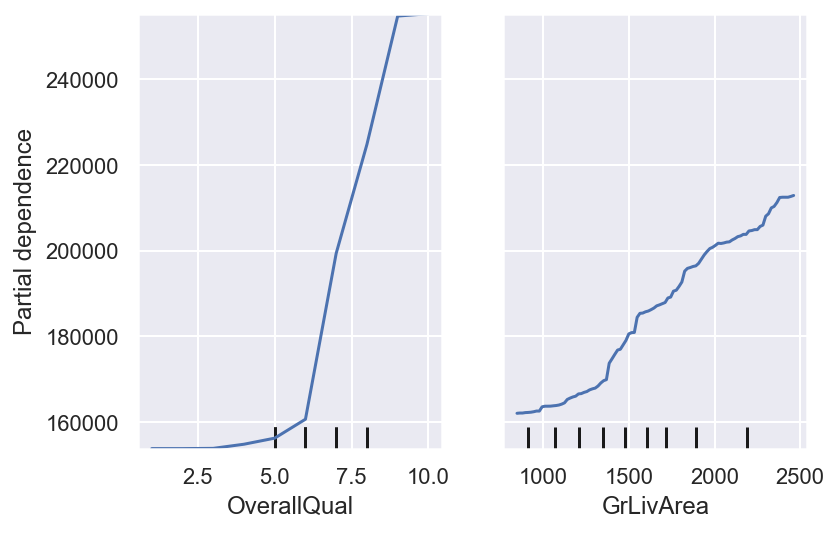

In [15]:
from sklearn.inspection import plot_partial_dependence
features = ["OverallQual", "GrLivArea"]
plot_partial_dependence(rforest, X_train, features, method="brute")
plt.show()

___Comentario___
<br>

`El an√°lisis de las gr√°ficas de dependendia parcial muestra que en el caso de la variable 'OverallQual', a partir de valores mayores que 6 aproximadamente existe una relaci√≥n lineal fuerte entre la variable y el precio de la vivienda. En el caso de 'GrLivArea' vemos que existe tambi√©n una relaci√≥n lineal entre la variable y el precio de la vivienda.`
<br>





<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

El gr√°fico anterior nos permite visualizar de forma global la relaci√≥n de las variables con la salida. Imaginemos ahora que nos encontramos en la siguiente situaci√≥n: una persona quiere poner a la venta su vivienda, pero el precio de venta que predecimos es m√°s bajo del esperado. ¬øPodemos explicarle el motivo de dicho resultado?


En este caso, se pretende expicar por qu√© obtenemos una predicci√≥n espec√≠fica para una muestra espec√≠fica. En estos casos, podemos utilizar SHAP para estudiar c√≥mo los valores de las distintas variables afectan a la salida.

In [16]:
#!pip install shap

In [17]:
import shap

shap.initjs()

Vamos a estudiar algunas muestras individuales del conjunto de test para simular distintas situaciones. En concreto, vamos a seleccionar las muestras m√°s cercanas a los percentiles 0, 0.25, 0.5, 0.75 y 1 (en cuanto a valor de *y*) en las predicciones del conjunto de test. El 0 corresponder√° a la muestra con la predicci√≥n de precio m√°s bajo, mientras que 1 ser√≠a la muestra de test con la predicci√≥n m√°s alta.

In [18]:
y_pred = rforest.predict(X_test)
pcen = np.percentile(y_pred, [0, 25, 50, 75, 100], interpolation='nearest')
i_near = [abs(y_pred - i).argmin() for i in pcen]
samples = X_test.iloc[i_near, :]
samples.head()

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
Id                                                                              
1101         60.0     8400            2            5       1920          1950   
50           66.0     7742            5            7       1966          1966   
800          60.0     7200            5            7       1937          1950   
1356        102.0    10192            7            6       1968          1992   
1183        160.0    15623           10            5       1996          1996   

      MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  SaleType_ConLw  \
Id                                                   ...                   
1101         0.0         290           0          0  ...               0   
50           0.0         763           0        192  ...               0   
800        252.0         569           0        162  ...               0   
1356       143.0           0           0        570  ...               0   
1183         0.0        2096           0        300  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
Id                                                                     
1101             0             0            1                      0   
50               0             0            1                      0   
800              0             0            1                      0   
1356             0             0            1                      0   
1183             0             0            1                      1   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
Id                                                                        
1101                      0                     0                     0   
50                        0                     0                     0   
800                       0                     0                     0   
1356                      0                     0                     0   
1183                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
Id                                                 
1101                     1                      0  
50                       1                      0  
800                      1                      0  
1356                     1                      0  
1183                     0                      0  

[5 rows x 226 columns]

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 5</font> 

Dibujar los gr√°ficos de fuerzas SHAP para cada una de las 5 muestras seleccionadas. Comentar los resultados.

In [25]:
explainer = shap.TreeExplainer(rforest)
sampleID=samples.index

In [26]:
sample = 0
choosen_instance = samples.loc[[sampleID[sample]]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [27]:
sample = 1
choosen_instance = samples.loc[[sampleID[sample]]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [28]:
sample = 2
choosen_instance = samples.loc[[sampleID[sample]]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [29]:
sample = 3
choosen_instance = samples.loc[[sampleID[sample]]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [30]:
sample = 4
choosen_instance = samples.loc[[sampleID[sample]]]
shap_values = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

___Comentario___
<br>

`En los gr√°ficos de fuerzas SHAP observamos unos resultados parecidos a los ejercicios anterior, podemos observar que las variables que han tenido m√°s peso en la clasificaci√≥n en todas las muestras (tanto a la alza como a la baja), han sido OverallQual y GrLivArea, esto demuestra la relevancia de estas variables a la hora de determinar el valor de la casa. Vemos que como era de esperar, cuanto mayor es el valor de estas variables m√°s tiende el modelo a hacer predicciones de valor elevado de la casa, como es el caso de las muestras 3 y 4, por el contrario en las muestras 0, 1 y 2 el reducido valor de OverallQual ha llevado a hacer predicciones m√°s bajas en respecto al precio de la casa.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 6</font> 

Dibuja un resumen global de los valores SHAP de todas las muestras de test con `summary_plot`. Comentar los resultados.

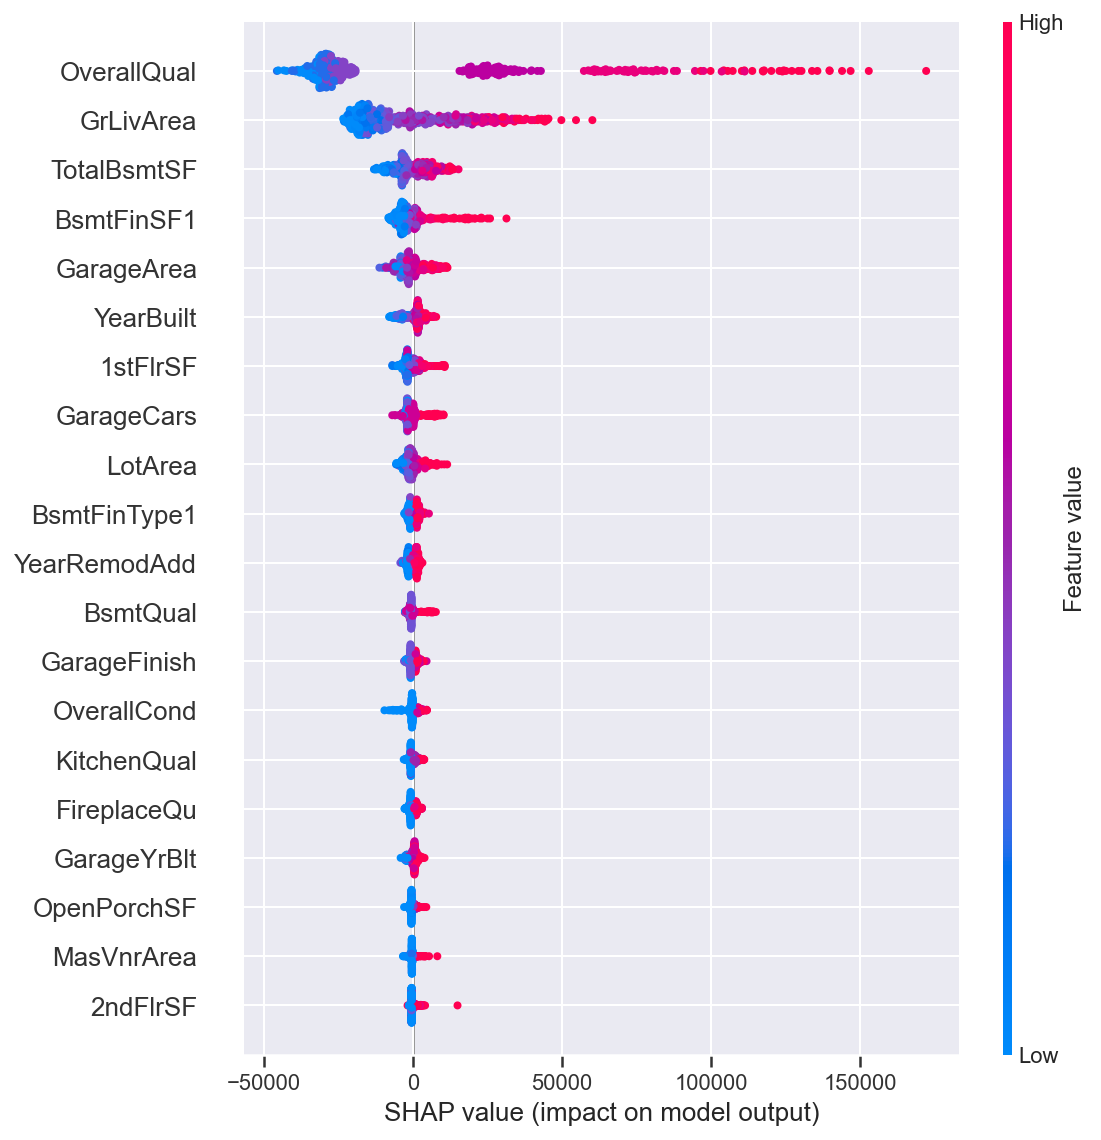

In [33]:
shap.summary_plot(explainer.shap_values(X_test), X_test)

___Comentario___
<br>

`EL resultado nuevamente nos indica la importancia de las variables OverallQual y GrLivArea a la hora de determinar el valor de la casa. Podemos observar que estas variables tienen la capacidad de incidir tanto positivamente como negativamente en el valor de la casa. Otras variables, como por ejemplo OverallCond parecen solo tener cierta importancia a la hora de generar predicciones de valor m√°s reducidas. Esto tiene todo el sentido en este caso, ya que un valor que indique que la condicion en la casa es buena puede no ser muy relevante, pero que la condici√≥n de la casa sea mala puede afectar en buena medida al precio. Al contrario otras variables como GarajeCars ocurre lo contrario teniendo importancia a la hora de impulsar una predicci√≥n m√°s alta, tambi√©n entendible ya que puede suponer esta variable que no tenga garaje o que si lo tenga y su tama√±o. Pero lo que queda claro con el gr√°fico es que para casi todas las predicciones, las variables OverallQual y GrLivArea tienen mucha m√°s importancia a la hora de generar la predicci√≥n.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section7"></a>
## <font color="#00586D"> 7. KNN</font>
<br>

Anteriormente se han usado algunos m√©todos param√©tricos (regresi√≥n) y no param√©tricos (√°rboles y *Random Forest*) para la predicci√≥n. KNN es otro m√©todo no param√©trico muy sencillo.


#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 7</font> 

Entrenar un modelo de predicci√≥n utilizando el vecino m√°s cercano. Como el conjunto de datos no es excesivamente alto en relaci√≥n a las caracter√≠sticas, y este algoritmo es muy sensible a la "*Maldici√≥n de la dimensionalidad"*, en esta prueba se utilizar√°n solamente las caracter√≠sticas num√©ricas relevantes obtenidas anteriormente con *Random Forest*, y almacenadas en `relevant_feat` durante el proceso de exploraci√≥n.  

In [34]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
k=1
knn.set_params(n_neighbors = k)
knn.fit(X_train[relevant_feat], y_train)

description = '1-NN (Relevant)'
show_results(description, knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

Training 		xValidation 		Test
-------- 		----------- 		----
R¬≤ = 1.000		R¬≤ = 0.503		R¬≤ = 0.610
MAE = 0.00					MAE = 32802.02


Puede apreciarse que el rendimiento de este algoritmo es muy pobre ($R^2=0.504$ en validaci√≥n). A continuaci√≥n se crear√° un *pipeline* para estandarizar los datos antes de hacer la predicci√≥n.

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_knn = Pipeline([('scaler', StandardScaler()),
                    ('clas', KNeighborsRegressor())])

pipe_knn.fit(X_train[relevant_feat], y_train)

description = '1-NN (Relevant-STD)'
show_results(description, pipe_knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

Training 		xValidation 		Test
-------- 		----------- 		----
R¬≤ = 0.875		R¬≤ = 0.803		R¬≤ = 0.773
MAE = 17295.36					MAE = 21264.16


En este caso, sube de manera sustancial el $R^2$ para el conjunto de validaci√≥n. ¬øQu√© sucece?

___Comentario___
<br>

`EN este caso, al utilizar un algoritmo de KNeighbors, que esta basado en las distancias, es muy importante estandarizar las variables, ya que en caso contrario, algunas variables que per se tengan valores m√°s elevados van a tener m√°s peso en el c√≥mputo de las distancias, haciendo que produzcan un sesgo en el modelo que no tiene necesariamente por qu√© explicar la variabilidad en las muestras. Por eso es mejor realizar un paso de escalado.`
<br>


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 8</font> 

Analizar el funcionamiento de KNN con distintos valores para `k`, utilizando pesos uniformes o inversos a la distancia para agregar los valores de los vecinos. En primer lugar, utilizando **todas las variables** (`X_train`) y estandarizaci√≥n.

In [40]:
KNeighborsRegressor().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [42]:
pipe_knn = Pipeline([('scaler', StandardScaler()),
                    ('knn', KNeighborsRegressor())])

parameters = {'knn__n_neighbors':(1,5,10,15,20), 'knn__weights':('uniform','distance')}
search = GridSearchCV(pipe_knn, param_grid=parameters, cv=5)
search.fit(X_train, y_train)

print(search.best_params_, end='\n\n')

knn = search.best_estimator_
description = 'k-NN (STD)'
show_results(description, knn, X_train, y_train, X_test, y_test)

{'knn__n_neighbors': 10, 'knn__weights': 'distance'}

Training 		xValidation 		Test
-------- 		----------- 		----
R¬≤ = 1.000		R¬≤ = 0.732		R¬≤ = 0.698
MAE = 0.00					MAE = 25710.12


Puede hacerse la predicci√≥n utilizando solamente las caracter√≠sticas relevantes obtenidas con `Random Forest` (`relevant_feat`).

In [43]:
pipe_knn = Pipeline([('scaler', StandardScaler()),
                    ('knn', KNeighborsRegressor())])

parameters = {'knn__n_neighbors':(1,5,10,15,20), 'knn__weights':('uniform','distance')}
search = GridSearchCV(pipe_knn, param_grid=parameters, cv=5)
search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')
knn = search.best_estimator_

description = 'k-NN (STD - Relevant)'
show_results(description, knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'knn__n_neighbors': 10, 'knn__weights': 'distance'}

Training 		xValidation 		Test
-------- 		----------- 		----
R¬≤ = 1.000		R¬≤ = 0.810		R¬≤ = 0.792
MAE = 0.00					MAE = 20210.55


Comparar y comentar los resultados de ambas pruebas.

___Comentario___
<br>

`Vemos que para ambos casos, los par√°metros seleccionados como los mejores son los mismos, por un lado un n√∫mero de veciones de 10 y pesos basados en las distancias. Podemos observar adem√°s que cuando utilizamos solamente las caracter√≠sticas relevantes obtenidas por Random Forest los valores de validaci√≥n y test mejoran notablemente, incluso siendo algo mejores que los obtenidos en el ejercicio anterior. Aqu√≠ vemos la importancia de la maldici√≥n de la dimensionalidad que hace que los clasificadores de este tipo empeoren cuando el n√∫mero de caracter√≠sticas es muy elevado.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section8"></a>
## <font color="#00586D"> 8. Construcci√≥n de caracter√≠sticas</font>
<br>

La construcci√≥n de caracter√≠sticas puede llevarse a cabo de varias formas. Un enfoque es el que se apoya en una construcci√≥n exhaustiva, como por ejemplo se puede hacer con el m√≥dulo *Feature Creation* de la librer√≠a `feature-engine`[**(+ Inf)**](https://feature-engine.readthedocs.io/en/latest/index.html), seguida de selecci√≥n; un segundo enfoque se basa en la construcci√≥n mediante t√©cnicas m√°s complejas, como la programaci√≥n gen√©tica+autoML; por √∫ltimo, tambi√©n es posible construir caracter√≠sticas de manera manual a partir de la exploraci√≥n. En este proyecto utilizaremos este √∫ltimo enfoque para construir algunas caracter√≠sticas sencillas. Para ello utilizaremos un conjunto de datos auxiliar, al que denominaremos `data_feat()`.

In [48]:
data_feat = data.copy()

Durante la exploraci√≥n se observ√≥ que la distribuci√≥n del precio de venta est√° claramente sesgada. En estos casos, es conveniente trabajar con el logaritmo. 

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 9</font> 

Calcular el logaritmo de los valores de la columna `data_feat['SalePrice'] `, almacenar el resultado en `data_feat['SalePrice']` y visualizar la distribuci√≥n con una gr√°fica de  tipo `histplot`.

In [49]:
data_feat['SalePrice'] = np.log(data_feat['SalePrice'])

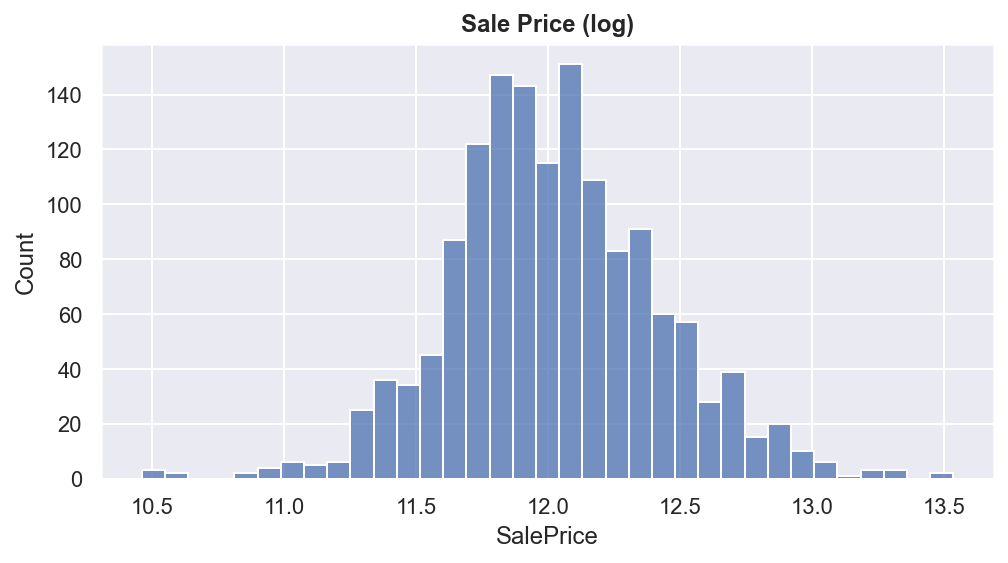

In [59]:
plt.figure(figsize=(8,4))
sns.histplot(data_feat['SalePrice'])
plt.title("Sale Price (log)", fontweight="bold")
plt.show()

Tambi√©n se ha observado que la relaci√≥n de la variable `OveralQuality`, una de las m√°s correlacionadas, era m√°s fuerte con respecto al logaritmo de la variable `SalesPrice`.

Otra variable imortante, `GrLivArea`, tambi√©n est√° sesgada. Sustituirla tambi√©n por su logaritmo.

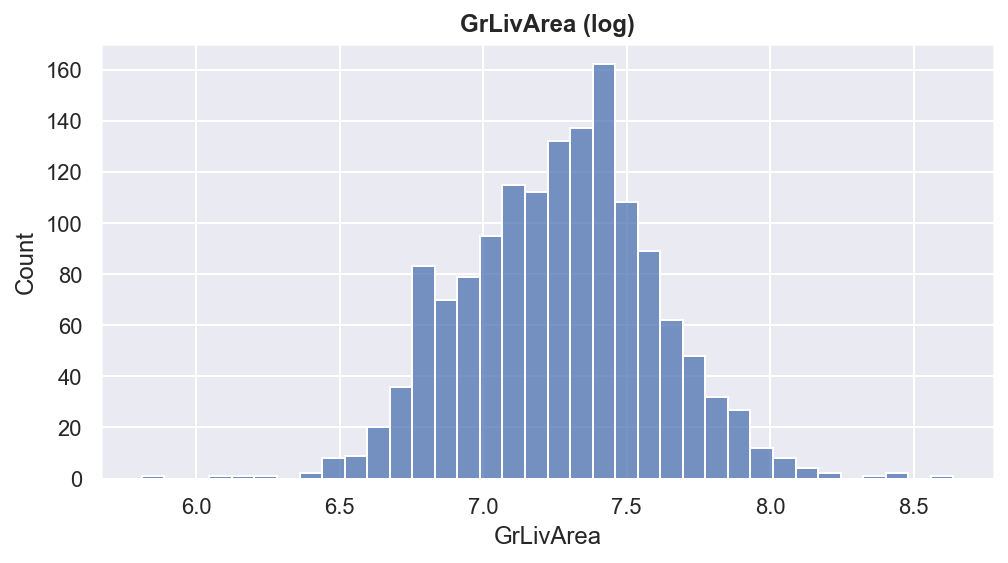

In [60]:
data_feat['GrLivArea'] = np.log(data_feat['GrLivArea'])
plt.figure(figsize=(8,4))
sns.histplot(data_feat['GrLivArea'])
plt.title("GrLivArea (log)", fontweight="bold")
plt.show()

Por √∫ltimo, algunas variables num√©ricas representan datos temporales. Por ejemplo, en este conjunto de datos, el mes de venta. Aunque su repercursi√≥n no es muy fuerte, es conveniente saber tratar estas variables, ya que aparecen a menudo en distintos consumos de datos. A continuaci√≥n se muestra la distribuci√≥n de los precios en funci√≥n del mes. 

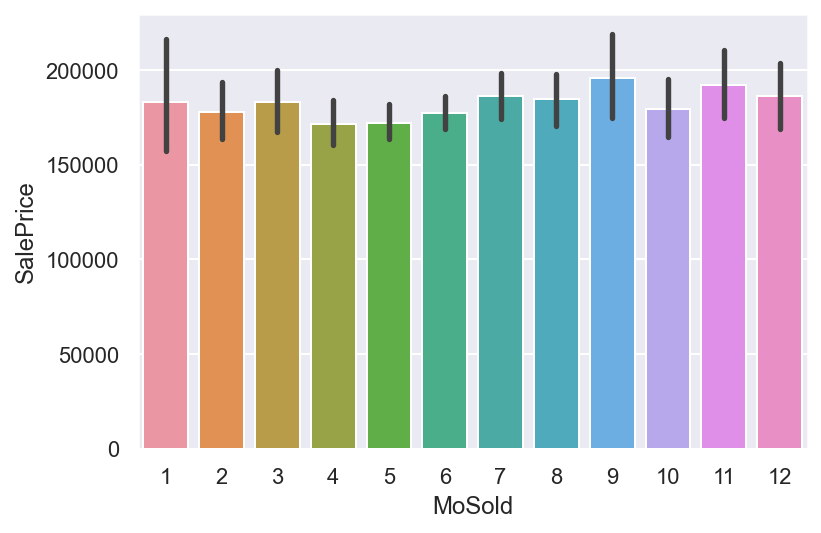

In [61]:
data_feat.sort_values(by='MoSold', inplace=True)
ax = sns.barplot(x=data_feat['MoSold'].astype('str'), y=data['SalePrice']);

Puede observarse que existe cierta oscilaci√≥n en los precios y que depende del mes. Tambi√©n que el mes 1 y el 12, que representan valores extremos, realmente deber√≠an ser similares, porque se suceden en el tiempo y, adem√°s, los precios medios son similares tambi√©n. Vemos que los precios bajan en mayo y junio, y crecen en septiembre-noviembre. Estas particularidades no se representan mediante una relaci√≥n lineal, pero se pueden representar mejor con una funci√≥n sinusoidal.

(1.0, 13.0)

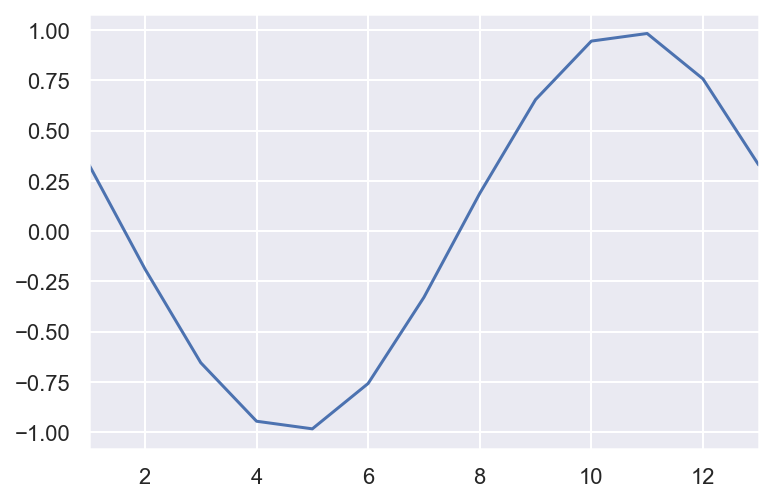

In [62]:
t = np.linspace(1,13, 13, endpoint=True)
ft = np.sin(2*np.pi*t/12-4)

plt.plot(t,ft)
plt.xlim(1,13)

Sustituir los valores de la columna `data_feat['MoSold']` por los obtenidos al calcular la funci√≥n sinusoidal anterior.

In [66]:
data_feat['MoSold'] = data_feat['MoSold'].map(lambda x: np.sin(2*np.pi*x/12-4))

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

Una vez transformadas las tres variables, se volver√°n a obtener los conjuntos de entrenamiento y test, ahora con algunas caracter√≠sticas transformadas.

In [67]:
from sklearn.model_selection import train_test_split

X = data_feat.drop(columns='SalePrice').copy()
y = data_feat['SalePrice'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 10</font> 

Volver a obtener los modelos de regresi√≥n lineal y √°rbol de regresi√≥n utilizando los conjuntos de datos obtenidos al transformar las caracter√≠sticas. Mostrar los resultados (visualizar el *DataFrame* `results`), y comentarlos.

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
Como la variable `SalePrice` es ahora un logaritmo, es necesario deshacer esa transformaci√≥n para hacer el MAE. Esto solo implica pasar el argumento `is_log=True` a la funci√≥n `show_results`. 
<br>

Para KNN, utilizad el *pipeline* para estandarizar los datos, y solo las caracter√≠sticas inclu√≠das en `relevant_feat`.
</div>

In [68]:
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(), param_grid=parameters, cv=5)
search.fit(X_train, y_train)
print(search.best_params_, end='\n\n')

ridge = search.best_estimator_
description = 'Ridge regression (FT)'
show_results(description, ridge, X_train, y_train, X_test, y_test, True)

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R¬≤ = 0.938		R¬≤ = 0.900		R¬≤ = 0.835
MAE = 12321.07					MAE = 17959.86


In [69]:
parameters = {'max_depth':np.linspace(1,15,15), 'min_samples_split':(2,4,6,8,10)}
search = GridSearchCV(DecisionTreeRegressor(), param_grid=parameters, cv=5)
search.fit(X_train, y_train)
print(search.best_params_, end='\n\n')

tree = search.best_estimator_
description = 'Regression tree (FT)'
show_results(description, tree, X_train, y_train, X_test, y_test, True)

{'max_depth': 12.0, 'min_samples_split': 8}

Training 		xValidation 		Test
-------- 		----------- 		----
R¬≤ = 0.980		R¬≤ = 0.734		R¬≤ = 0.738
MAE = 7192.79					MAE = 25834.78


In [70]:
parameters = {'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestRegressor(), param_grid=parameters, cv=5)
search.fit(X_train, y_train)
print(search.best_params_, end='\n\n')

rforest = search.best_estimator_
description = 'Random forest (FT)'
show_results(description, rforest, X_train, y_train, X_test, y_test, True)

{'max_depth': 15}

Training 		xValidation 		Test
-------- 		----------- 		----
R¬≤ = 0.982		R¬≤ = 0.864		R¬≤ = 0.859
MAE = 6680.75					MAE = 18579.63


In [71]:
pipe_knn = Pipeline([('scaler', StandardScaler()),
                    ('knn', KNeighborsRegressor())])

parameters = {'knn__n_neighbors':(1,5,10,15,20), 'knn__weights':('uniform','distance')}
search = GridSearchCV(pipe_knn, param_grid=parameters, cv=5)
search.fit(X_train[relevant_feat], y_train)
print(search.best_params_, end='\n\n')
knn = search.best_estimator_

description = 'k-NN (STD - Relevant - FT)'
show_results(description, knn, X_train[relevant_feat], y_train, X_test[relevant_feat], y_test)

{'knn__n_neighbors': 10, 'knn__weights': 'distance'}

Training 		xValidation 		Test
-------- 		----------- 		----
R¬≤ = 1.000		R¬≤ = 0.832		R¬≤ = 0.814
MAE = 0.00					MAE = 0.12


In [72]:
results

$R^2$ Entrenamiento  $R^2$ Validaci√≥n  \
Modelo                                                               
Ridge regression                        0.907758          0.845827   
Regression tree                         0.875838          0.714649   
Random forest                           0.975375          0.854910   
Ridge regression (Relevant)             0.839021          0.825211   
Regression tree (Relevant)              0.952867          0.705807   
Random forest (Relevant)                0.980405          0.848169   
1-NN (Relevant)                         1.000000          0.502643   
1-NN (Relevant-STD)                     0.875446          0.803151   
k-NN (STD)                              1.000000          0.732469   
k-NN (STD - Relevant)                   1.000000          0.809519   
Ridge regression (FT)                   0.938080          0.899517   
Regression tree (FT)                    0.980168          0.734429   
Random forest (FT)                      0.981755          0.864439   
k-NN (STD - Relevant - FT)              0.999990          0.832122   

                             $R^2$ Test  MAE Entrenamiento      MAE Test  
Modelo                                                                    
Ridge regression               0.775932       15187.837606  19274.550173  
Regression tree                0.746025       20723.767792  26413.953028  
Random forest                  0.857188        7813.421346  17211.625273  
Ridge regression (Relevant)    0.714174       20444.036513  21965.317969  
Regression tree (Relevant)     0.802087       12982.552518  23764.297222  
Random forest (Relevant)       0.855623        6685.408496  17760.180492  
1-NN (Relevant)                0.609653           0.000000  32802.022822  
1-NN (Relevant-STD)            0.773045       17295.361759  21264.161826  
k-NN (STD)                     0.698286           0.000136  25710.122559  
k-NN (STD - Relevant)          0.792360           0.000014  20210.552208  
Ridge regression (FT)          0.834511       12321.067014  17959.855532  
Regression tree (FT)           0.738463        7192.794132  25834.784286  
Random forest (FT)             0.858918        6680.746064  18579.632329  
k-NN (STD - Relevant - FT)     0.814259           0.000058      0.115436

___Comentario___
<br>

`Lo que podemos observar es que en la mayor√≠a de modelos podemos observar cierta mejor√≠a. En el caso de Ridge y kNN la diferencia es m√°s notable y parece ser que para el √°rbol de regresi√≥n y Random Forest el resultado se ve menos afectado.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section9"></a>
## <font color="#00586D"> 9. Descarte de outliers</font>
<br>

Llegado a este punto se aprecia que el mejor resultado se ha obtenido con la regresi√≥n regularizada (nos basamos en la validaci√≥n para la selecci√≥n de modelos), tras transformar algunas caracter√≠sticas, y utilizando todas las dem√°s.  En algunos casos, los valores an√≥malos pueden perjudicar al modelo. En regresi√≥n, por ejemplo, pueden hacer que alg√∫n coeficiente se altere de manera sustancial, sobre todo si el conjunto de datos no es grande.

Por √∫ltimo, se comprobar√° el efecto de eliminar valores an√≥malos. 




#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 11</font> 

Utilizar un modelo *Isolation Forest* para "marcar" las muestras que son *outliers*, tanto en el conjunto de entrenamiento como en el conjunto de test. Utilizar una contaminaci√≥n del 0.5%.  Generar dos vectores (`out_train` y `out_test`) con los resultados (1 para valores normales, y -1 para *outliers*). ¬øCuantos *outliers* hay en el conjunto de entrenamiento? ¬øY en el de test?

In [76]:
from sklearn.ensemble import IsolationForest

iforest =  IsolationForest(n_estimators=100, contamination=0.005)
iforest.fit(X_train)
out_train =  iforest.predict(X_train)
iforest.fit(X_test)
out_test =  iforest.predict(X_test)

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 12</font> 

Eliminar los outliers  de los conjuntos de entrenamiento y test, y entrenar el modelo de regresi√≥n lineal regularizada (el mejor modelo hasta el momento). ¬øQu√© resultados se obtienen?

In [97]:
X_train_out=X_train.loc[[True if x==1 else False for x in out_train]]
y_train_out=y_train.loc[[True if x==1 else False for x in out_train]]
X_test_out=X_test.loc[[True if x==1 else False for x in out_test]]
y_test_out=y_test.loc[[True if x==1 else False for x in out_test]]

In [98]:
parameters = {'alpha':np.logspace(-4, 4, 9, endpoint=True)}
search = GridSearchCV(Ridge(), param_grid=parameters, cv=5)
search.fit(X_train_out, y_train_out)
print(search.best_params_, end='\n\n')

ridge = search.best_estimator_
description = 'Ridge regression (FT - No Outliers)'
show_results(description, ridge, X_train_out, y_train_out, X_test_out, y_test_out, True) 

{'alpha': 10.0}

Training 		xValidation 		Test
-------- 		----------- 		----
R¬≤ = 0.947		R¬≤ = 0.919		R¬≤ = 0.915
MAE = 11565.41					MAE = 14140.58


In [99]:
results

$R^2$ Entrenamiento  $R^2$ Validaci√≥n  \
Modelo                                                                       
Ridge regression                                0.907758          0.845827   
Regression tree                                 0.875838          0.714649   
Random forest                                   0.975375          0.854910   
Ridge regression (Relevant)                     0.839021          0.825211   
Regression tree (Relevant)                      0.952867          0.705807   
Random forest (Relevant)                        0.980405          0.848169   
1-NN (Relevant)                                 1.000000          0.502643   
1-NN (Relevant-STD)                             0.875446          0.803151   
k-NN (STD)                                      1.000000          0.732469   
k-NN (STD - Relevant)                           1.000000          0.809519   
Ridge regression (FT)                           0.938080          0.899517   
Regression tree (FT)                            0.980168          0.734429   
Random forest (FT)                              0.981755          0.864439   
k-NN (STD - Relevant - FT)                      0.999990          0.832122   
Ridge regression (FT - No Outliers)             0.946852          0.918791   

                                     $R^2$ Test  MAE Entrenamiento  \
Modelo                                                               
Ridge regression                       0.775932       15187.837606   
Regression tree                        0.746025       20723.767792   
Random forest                          0.857188        7813.421346   
Ridge regression (Relevant)            0.714174       20444.036513   
Regression tree (Relevant)             0.802087       12982.552518   
Random forest (Relevant)               0.855623        6685.408496   
1-NN (Relevant)                        0.609653           0.000000   
1-NN (Relevant-STD)                    0.773045       17295.361759   
k-NN (STD)                             0.698286           0.000136   
k-NN (STD - Relevant)                  0.792360           0.000014   
Ridge regression (FT)                  0.834511       12321.067014   
Regression tree (FT)                   0.738463        7192.794132   
Random forest (FT)                     0.858918        6680.746064   
k-NN (STD - Relevant - FT)             0.814259           0.000058   
Ridge regression (FT - No Outliers)    0.914603       11565.413760   

                                         MAE Test  
Modelo                                             
Ridge regression                     19274.550173  
Regression tree                      26413.953028  
Random forest                        17211.625273  
Ridge regression (Relevant)          21965.317969  
Regression tree (Relevant)           23764.297222  
Random forest (Relevant)             17760.180492  
1-NN (Relevant)                      32802.022822  
1-NN (Relevant-STD)                  21264.161826  
k-NN (STD)                           25710.122559  
k-NN (STD - Relevant)                20210.552208  
Ridge regression (FT)                17959.855532  
Regression tree (FT)                 25834.784286  
Random forest (FT)                   18579.632329  
k-NN (STD - Relevant - FT)               0.115436  
Ridge regression (FT - No Outliers)  14140.582447

___Comentario___
<br>

`Vemos que al eliminar los outliers los valores tanto en validaci√≥n como test han mejorado notablemente, convirtiendose este en el mejor modelo hasta el momento y consiguiendo ya un valor de R2 por encima de 0.9 tanto para validaci√≥n como para test.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Importante__: Incorporar este paso al pipeline ser√≠a bastante complejo porque no solo modificamos columnas, sino que eliminamos filas. Habr√≠a que hacer un *metaclasificador* que primero determine si un valor es un outlier o no, y en funci√≥n de eso devuelva el resultado (que puede ser -1 para un caso, y la predicci√≥n para otro). La implementaci√≥n de este *pipeline* constituye un ejercicio interesante.
</div>

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section10"></a>
## <font color="#00586D">10. Aprendizaje no supervisado: PCA, Manifold y EM</font>
<br>

Para analizar el conjunto de datos mediante aprendizaje no supervisado se partir√° del conjunto de datos original. En este caso trabajaremos solamente con las caracter√≠cticas num√©ricas m√°s relevantes y el precio.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> Estos ejercicios **no son una continuaci√≥n** de los relacionados con el modelo predictivo, sino que constituyen una estudio independiente. 
</div>

In [110]:
feat = ['OverallQual',
        'GrLivArea',
        'ExterQual',
        'KitchenQual',
        'GarageArea',
        'TotalBsmtSF',
        '1stFlrSF',
        'TotRmsAbvGrd',
        'YearBuilt',
        'SalePrice']

data_small = data[feat]
X_small = data_small.drop(columns='SalePrice').copy()
y_small = data_small['SalePrice'].copy()
data_small.head()

OverallQual  GrLivArea  ExterQual  KitchenQual  GarageArea  TotalBsmtSF  \
Id                                                                            
1             7       1710          4            4         548          856   
2             6       1262          3            3         460         1262   
3             7       1786          4            4         608          920   
4             7       1717          3            4         642          756   
5             8       2198          4            4         836         1145   

    1stFlrSF  TotRmsAbvGrd  YearBuilt  SalePrice  
Id                                                
1        856             8       2003     208500  
2       1262             6       1976     181500  
3        920             6       2001     223500  
4        961             7       1915     140000  
5       1145             9       2000     250000

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 13</font>

Utilizar PCA para reducir la dimensionalidad del conjunto de datos `data`. Utilizar dos componentes y almacenar la proyecci√≥n en una variable denominada `data_pc`. Mostrar la proporci√≥n de varianza mostrada por cada componente. Dibujar una gr√°fica de dispersi√≥n con los valores de las dos primeras caracter√≠sticas creadas (proyecciones correspondientes a las dos componentes). ¬øQu√© se observa? (Se puede utilizar como color, por ejemplo, `hue=data['SalePrice']`).

In [132]:
from sklearn.decomposition import PCA

pca =  PCA(n_components=2)
pca.fit(X_small)
data_pc = pca.transform(X_small) 

print(f'N√∫mero de componentes: {data_pc.shape[1]}')

N√∫mero de componentes: 2


In [133]:
df_pca=pd.DataFrame(data_pc, columns=["PC1", "PC2"], index=data_small.index)

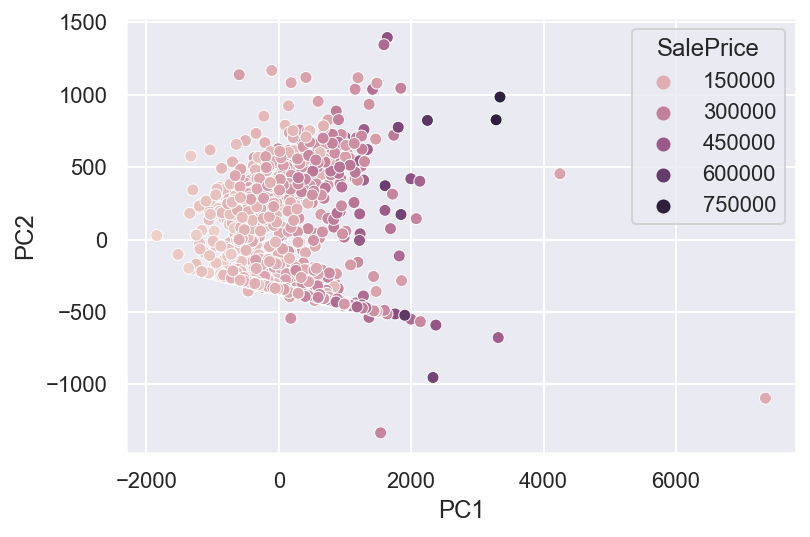

In [134]:
sns.scatterplot(x = "PC1", y = "PC2", data = df_pca, hue=data['SalePrice']);

Muestra las cargas de las dos componentes (los 5 valores m√°s importantes)

In [135]:
sorted(zip(data_small.columns,pca.components_[0]), key=lambda pair: pair[1], reverse=True)[:5]

[('GrLivArea', 0.653562745572474),
 ('TotalBsmtSF', 0.5370383674884146),
 ('1stFlrSF', 0.4985930620587334),
 ('GarageArea', 0.18871618167276533),
 ('YearBuilt', 0.015235163951238067)]

In [136]:
sorted(zip(data_small.columns,pca.components_[1]), key=lambda pair: pair[1], reverse=True)[:5]

[('GrLivArea', 0.739118435164753),
 ('TotRmsAbvGrd', 0.0022428157456643037),
 ('OverallQual', 0.00028672687880801747),
 ('KitchenQual', 3.873424943778999e-06),
 ('ExterQual', -1.7891950633232528e-05)]

___Comentario___
<br>

`Vemos que la componente 1 es la que explica mejor las diferencias en el precio de la casa, la componente dos no parece haber tenido tanta relevancia en ese aspecto. Vemos que la carga de la primera componente influye en gran medida GrLivArea, TotalBsmtSF y 1stFlrSF. En cambio en la segunda componente, practicamente la carga es casi exclusivamente para la variable GrLivArea.`
<br>


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 14</font>




Construir un *pipeline* en el que el primer paso consista en escalar las caracter√≠sticas a media cero y desviaci√≥n uno mediante un objeto `StandardScaler`, y despu√©s se  repita el proceso anterior, almacenando la proyecci√≥n de los datos en `data_pc`. Mostrar el n√∫mero de componentes necesarias para retener el 99% de la varianza de los datos. ¬øSon ahora tan relevantes las dos primeras componentes? ¬øPor qu√©? ¬øCu√°nta varianza acumulan? ¬øPodr√≠an interpretarse de alg√∫n modo?

In [140]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


pipe_sc_pca = Pipeline([('scaler', StandardScaler()),
                    ('pca', PCA())])
pipe_sc_pca.fit(X_small)
data_pc = pipe_sc_pca.transform(X_small)

print(f'N√∫mero de componentes: {data_pc.shape[1]}')

N√∫mero de componentes: 9


In [145]:
print('Varianza explicada:', pipe_sc_pca.named_steps['pca'].explained_variance_)  
print('Varianza explicada ratio:', pipe_sc_pca.named_steps['pca'].explained_variance_ratio_)
print('Varianza explicada acumulada:', np.cumsum(pipe_sc_pca.named_steps['pca'].explained_variance_ratio_))

Varianza explicada: [4.85514152 1.38596897 0.95076011 0.54946623 0.42438759 0.29539471
 0.25163734 0.16057043 0.1328417 ]
Varianza explicada ratio: [0.53909068 0.15389108 0.10556766 0.06100999 0.04712188 0.03279915
 0.02794055 0.01782894 0.01475008]
Varianza explicada acumulada: [0.53909068 0.69298175 0.79854941 0.85955939 0.90668127 0.93948043
 0.96742098 0.98524992 1.        ]


Resultados del PCA anterior

In [148]:
print('Varianza explicada:', pca.explained_variance_)  
print('Varianza explicada ratio:', pca.explained_variance_ratio_)
print('Varianza explicada acumulada:', np.cumsum(pca.explained_variance_ratio_))

Varianza explicada: [465306.17343722 140280.27267401]
Varianza explicada ratio: [0.70005369 0.21105184]
Varianza explicada acumulada: [0.70005369 0.91110553]


In [146]:
sorted(zip(data_small.columns,pca.components_[0]), key=lambda pair: pair[1], reverse=True)[:5]

[('GrLivArea', 0.6535627455724742),
 ('TotalBsmtSF', 0.5370383674884144),
 ('1stFlrSF', 0.4985930620587333),
 ('GarageArea', 0.1887161816727652),
 ('YearBuilt', 0.015235163951238063)]

In [147]:
sorted(zip(data_small.columns,pca.components_[1]), key=lambda pair: pair[1], reverse=True)[:5]

[('GrLivArea', 0.7391184351647528),
 ('TotRmsAbvGrd', 0.0022428157456643033),
 ('OverallQual', 0.0002867268788080153),
 ('KitchenQual', 3.8734249437803e-06),
 ('ExterQual', -1.7891950633399062e-05)]

___Comentario___
<br>

`Para retener una varianza del 99% deber√≠amos retener 10 componentes, que es igual que el n√∫mero de variables inicial. Vemos que ahora las dos primeras componentes solo explican el 69% de la varianza, al contrario que en el ejercicio anterior donde explicaban el 91%, ahora estas dos primeras componentes son menos importantes y necesitamos un mayor n√∫mero de variables para explicar la varianza. Esto puede deberse a la ausencia de estandarizaci√≥n en el primer an√°lisis de PCA, ya que como las diferentes variables tienen diferentes escalas, con un par de variables que capten la varianza de las variables que mayores valores puedan llegar a tomar podr√≠a llevar a que el an√°lisis muestre que es capaz de explicar gran parte de la varianza con pocas componentes. Por ello es importante realizar el escalado, para que se intente explicar la varianza de todas las variables.`
<br>


<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 15</font>

Repetir el ejercicio anterior, pero utilizando ahora TSNE. Para ello, crear un *pipeline* en el que el primer paso corresponda a la estadarizaci√≥n, y el segundo a un modelo TSNE en el que `n_components=2`. Utilizarlo para transformar los datos en `data_small` y almacenar el resultado en un array denominado `data_vis`.

In [162]:
from sklearn.manifold import TSNE

pipe_sc_tsne = Pipeline([('scaler', StandardScaler()),
                    ('TSNE', TSNE(n_components=2))])
data_vis = pipe_sc_tsne.fit_transform(X_small)

print(f'N√∫mero de componentes: {data_vis.shape[1]}')

N√∫mero de componentes: 2


Elaborar una gr√°fica de dispersi√≥n con los datos de `data_vis`.

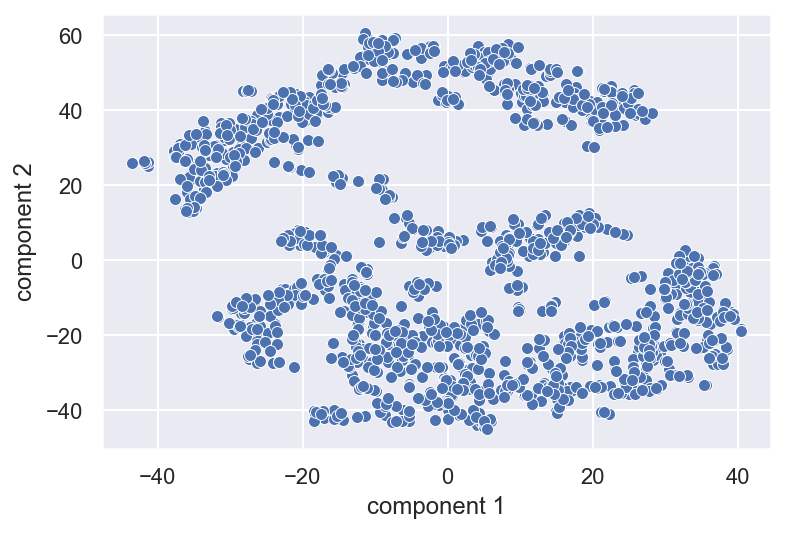

In [163]:
df_tsne=pd.DataFrame(data_vis, columns=["component 1", "component 2"], index=data_small.index)
sns.scatterplot(x = "component 1", y = "component 2", data = df_tsne);

Repetir la gr√°fica, pero utilizando `hue=data['SalePrice']` 

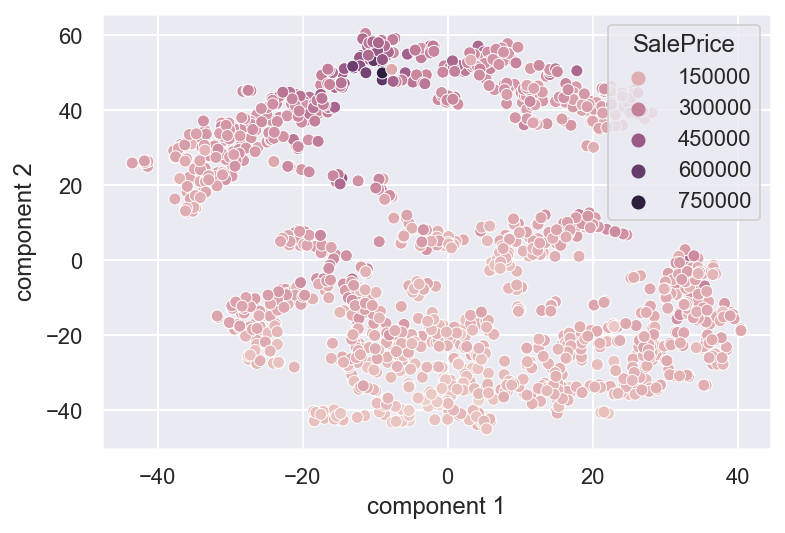

In [164]:
sns.scatterplot(x = "component 1", y = "component 2", data = df_tsne, hue=data_small['SalePrice']);

Probar a utilizar el color para mostrar otra variables, como por ejemplo `YearBuilt`.

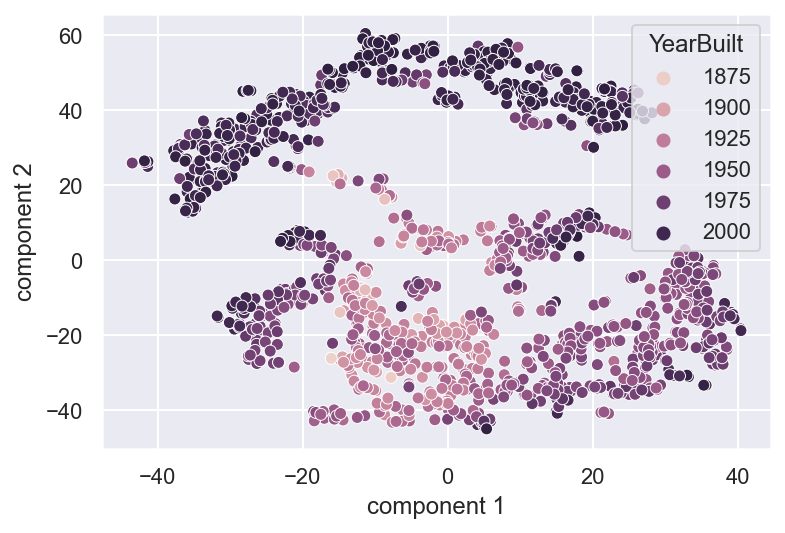

In [165]:
sns.scatterplot(x = "component 1", y = "component 2", data = df_tsne, hue=data_small['YearBuilt']);

___Comentario___
<br>

`En el caso de TSNE vemos que ahora ambas componentes tienen importancia para explicar los precios de las casas, el gr√°fico de dispersi√≥n genera un grupo separado claramente del resto, pero esto no se relaciona directamente con un mayor o menor precio de las casas, parece ser que este es el grupo de las casas m√°s modernas o que han sido contruidas hace menor tiempo.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

#### <font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" ></i> Ejercicio 16</font>

Por √∫ltimo, se va a utilizar el algoritmo EM (modelo `GaussianMixture`) para representar la distribuci√≥n de las viviendas que hay en `data_small`, y utilizando `n_components=2`.   En este caso, tambi√©n es necesario utilizar un *pipeline* en el que el primer paso consista en una estandarizaci√≥n, y el segundo el propio algoritmo. Almacenar el cluster al que pertenece cada vivienda en `cluster`.

In [166]:
from sklearn.mixture import GaussianMixture

pipe_sc_gm = Pipeline([('scaler', StandardScaler()),
                    ('GM', GaussianMixture(n_components=2))])
cluster = pipe_sc_gm.fit_predict(X_small)

Obtener la media de todas las columnas para cada uno de los grupos y compararlos. ¬øPuede hacerse alg√∫n tipo de interpretaci√≥n?

In [173]:
data_small["group"]=cluster
data_small.groupby("group").mean()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


OverallQual    GrLivArea  ExterQual  KitchenQual  GarageArea  \
group                                                                 
0         7.241877  1774.862816   4.043321     4.057762  594.680505   
1         5.400662  1356.846578   3.000000     3.177704  398.562914   

       TotalBsmtSF     1stFlrSF  TotRmsAbvGrd   YearBuilt      SalePrice  
group                                                                     
0      1276.377256  1317.236462      7.021661  1994.01444  240743.169675  
1       923.547461  1068.086093      6.209713  1957.35872  144341.313466

Otra forma de interpretar los clusters es mediante visualizaci√≥n. Mostrar una gr√°fica de dispersi√≥n con las columnas `GrLivArea` y `SalePrice`. Utilizar  `hue=cluster`. ¬øPuede hacerse alg√∫n tipo de interpretaci√≥n? 

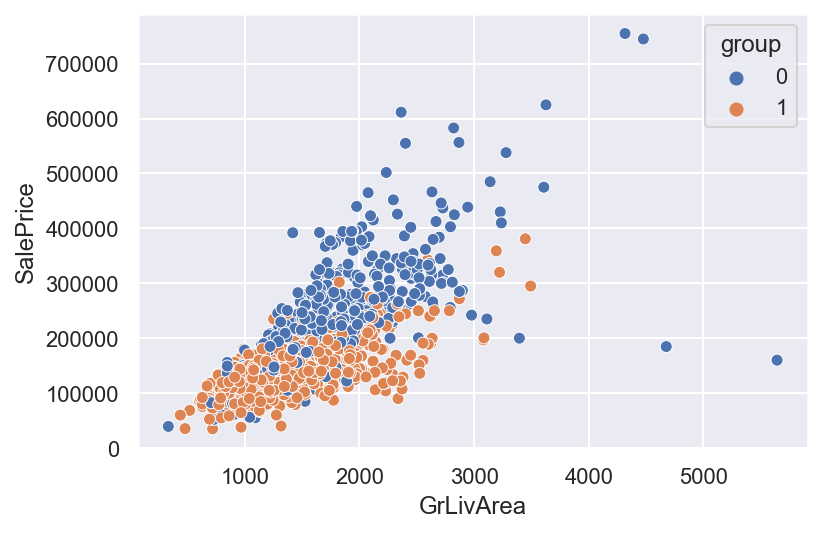

In [177]:
sns.scatterplot(x="GrLivArea", y="SalePrice", data=data_small, hue="group");

Elaborar ahora una gr√°fica de dispersi√≥n, pero con los datos de `data_pc`, utilizando otra vez `hue=cluster`. ¬øPuede hacerse alg√∫n tipo de interpretaci√≥n? 

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

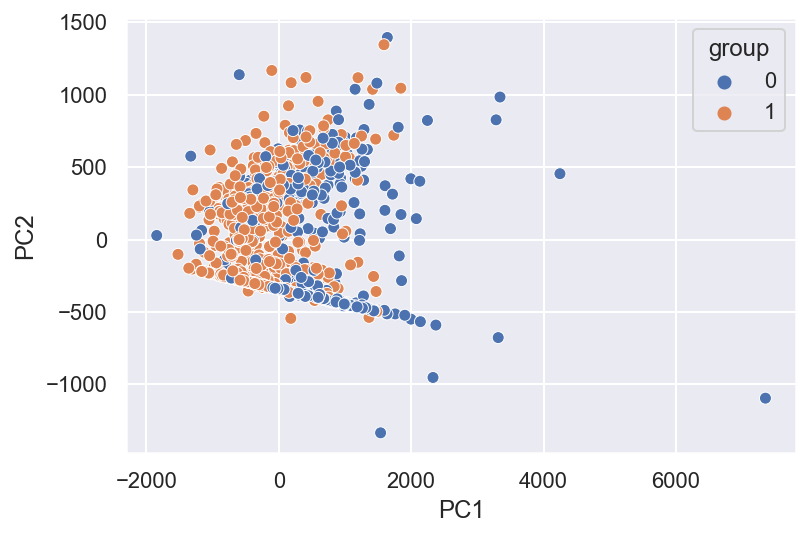

In [178]:
df_pca["group"]=cluster
sns.scatterplot(x="PC1", y="PC2", data=df_pca, hue="group")

Repetir la gr√°fica, pero con los datos en `data_vis`. ¬øPuede hacerse alg√∫n tipo de interpretaci√≥n? 

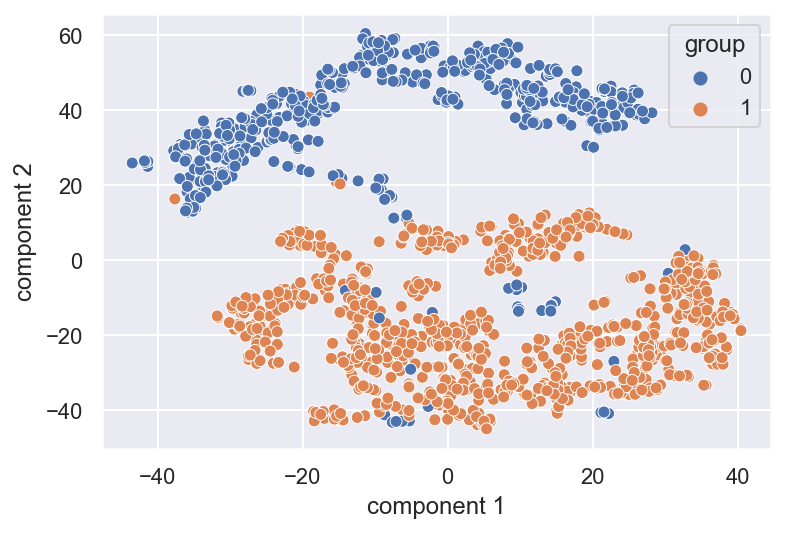

In [180]:
df_tsne["group"]=cluster
sns.scatterplot(x="component 1", y="component 2", data=df_tsne, hue="group");

___Comentario___
<br>

`Lo que podemos observar por la distribuci√≥n de las medias y el gr√°fico de disperso√≥n para cada uno de los cluster es que el grupo 0 corresponde con casas m√°s nuevas y que en general tienen un mayor precio de venta, adem√°s de que presentan mejores puntuaciones en casi todas las variables que se han considerado como importantes. Vemos que al hacer esta separaci√≥n por grupos obtenemos unas conclusiones similares a las que hab√≠amos obtenido anteriormente. En el caso del an√°lisis por PCA, la componente 1 es la que mejor explica las diferencias de precio y podemos ver como el grupo 0 (el caracter√≠stico por ser casas m√°s nuevas y mejor valoradas) parece agrupar y ser m√°s predominante para valores elevados de esta componente. En el caso de TSNE, vemos que las casas m√°s nuevas y mejor valoradas agrupan y forman un cluster diferenciado del resto, tal y como hab√≠amos descrito al analizar el resultado por TSNE, en este caso vemos que esas corresponden al grupo 0 del an√°lisis por GaussianMixture.`
<br>

<div><font size=3 color=#00586D> <i class="fa fa-check-square-o" aria-hidden="true"></i></font></div>

<!--comment -->

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<div align="right">
<a href="#indice"><font size=6 color="#00586D"><i class="fa fa-coffee" aria-hidden="true"></i></font></a>
</div>